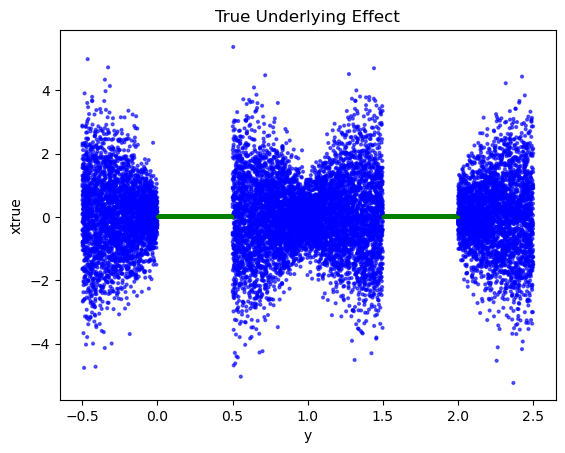

In [1]:
import math
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from cebmf_torch.torch_cebnm.spiked_emdn import spiked_mdn_posterior_means  # adjust path if solver file has another name
from cebmf_torch.torch_cebnm.emdn import emdn_posterior_means
# Reproducibility
torch.manual_seed(1)

# Generate data in PyTorch
n_samples = 20_000
y = torch.empty(n_samples).uniform_(-0.5, 2.5)        # U(-0.5, 2.5)
X = y.view(-1, 1)

# masks for zero vs nonzero regions
mask_zero = ((y > 0) & (y < 0.5)) | ((y > 1.5) & (y < 2.0))

# std depends on y
noise_std = 0.5 + torch.abs(torch.sin(math.pi * y))

# xtrue: 0 in masked regions, Gaussian elsewhere with that std
xtrue = torch.where(mask_zero, torch.zeros_like(y), torch.randn_like(y) * noise_std)

# Observed data
x = xtrue + torch.randn_like(xtrue)   # add N(0,1) noise
s = torch.ones_like(x)                # all ones
Z = torch.ones(n_samples, 1)          # design column of ones

# Plot
colors = torch.where(xtrue == 0, torch.tensor(0), torch.tensor(1))  # 0/1 labels
plt.scatter(y.cpu().numpy(), xtrue.cpu().numpy(),
            c=['green' if c == 0 else 'blue' for c in colors.tolist()],
            s=4, alpha=0.6)
plt.title('True Underlying Effect')
plt.xlabel('y'); plt.ylabel('xtrue')
plt.show()


In [2]:
res =  spiked_mdn_posterior_means(
    X=X,
    betahat=x,
    sebetahat=s,
    n_epochs=50,          
    n_layers=2 ,
    penalty=2.1
    
)


[Spiked-EMDN] Epoch 10/50, Loss: 1.8147
[Spiked-EMDN] Epoch 20/50, Loss: 1.8090
[Spiked-EMDN] Epoch 30/50, Loss: 1.8001
[Spiked-EMDN] Epoch 40/50, Loss: 1.8013
[Spiked-EMDN] Epoch 50/50, Loss: 1.8041


C:\Document\Serieux\Travail\python_work\package\cebmf_torch\src\cebmf_torch\torch_cebnm\spiked_emdn.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  location=torch.tensor(mu_full[i, :], dtype=torch.float32),
C:\Document\Serieux\Travail\python_work\package\cebmf_torch\src\cebmf_torch\torch_cebnm\spiked_emdn.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale=torch.tensor(sigma_full[i, :], dtype=torch.float32)  # spike scale=0 â‡’ total sd = se
C:\Document\Serieux\Travail\python_work\package\cebmf_torch\src\cebmf_torch\torch_cebnm\spiked_emdn.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

In [ ]:
res2 = emdn_posterior_means(
    X=X,
    betahat=x,
    sebetahat=s      ,
    n_epochs=50,          
    n_layers=1.2 
    
)

[EMDN] Epoch 10/50, Loss: 1.7044
[EMDN] Epoch 20/50, Loss: 1.7036
[EMDN] Epoch 30/50, Loss: 1.6978
[EMDN] Epoch 40/50, Loss: 1.6936
[EMDN] Epoch 50/50, Loss: 1.6974


Posterior means (first 10): tensor([ 1.0793e-05, -1.7050e-05,  2.5350e-01, -2.7648e-05,  3.7534e-01,
         1.0719e-05, -1.8174e+00, -2.0441e-04, -1.3120e-02,  6.8003e-01])
Posterior sds (first 10): tensor([0.0075, 0.0236, 0.8165, 0.0121, 0.9818, 0.0066, 1.4043, 0.0276, 0.1966,
        1.2281])
Fitted mixture weights shape: (20000, 5)


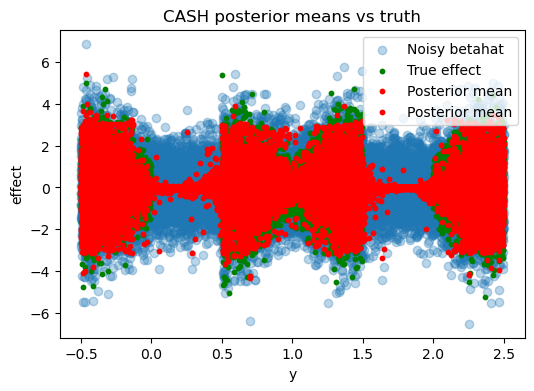

In [4]:


# -------------------
# Step 3: Inspect results
# -------------------
print("Posterior means (first 10):", res.post_mean[:10])
print("Posterior sds (first 10):", res.post_sd[:10])
print("Fitted mixture weights shape:", res.pi_np.shape)

# Plot true vs posterior means
plt.figure(figsize=(6,4))
plt.scatter(y, x, alpha=0.3, label="Noisy betahat")
plt.scatter(y, xtrue, c="green", s=10, label="True effect")
plt.scatter(y, res2.post_mean, c="red", s=10, label="Posterior mean")
plt.scatter(y, res.post_mean, c="red", s=10, label="Posterior mean")
plt.legend()
plt.xlabel("y")
plt.ylabel("effect")
plt.title("CASH posterior means vs truth")
plt.show()


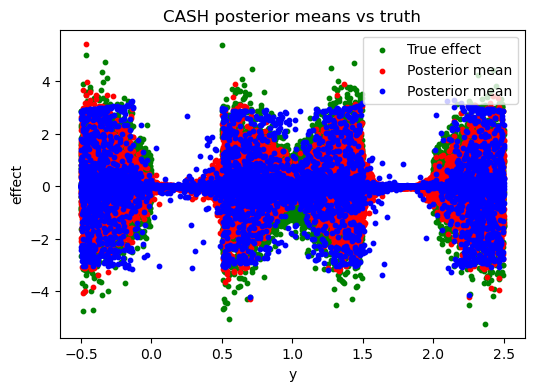

In [5]:
# Plot true vs posterior means
plt.figure(figsize=(6,4)) 
plt.scatter(y, xtrue, c="green", s=10, label="True effect")
plt.scatter(y, res2.post_mean, c="red", s=10, label="Posterior mean")
plt.scatter(y, res.post_mean, c="blue", s=10, label="Posterior mean")
plt.legend()
plt.xlabel("y")
plt.ylabel("effect")
plt.title("CASH posterior means vs truth")
plt.show()


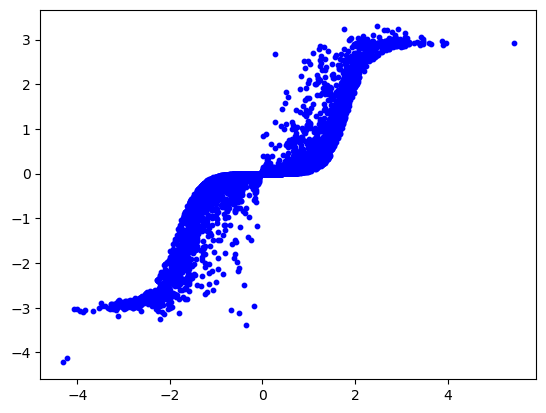

In [6]:
plt.scatter( res2.post_mean, res.post_mean, c="blue", s=10, label="Posterior mean")

In [7]:
res.post_mean

tensor([ 1.0793e-05, -1.7050e-05,  2.5350e-01,  ...,  8.9656e-02,
        -6.9218e-04, -1.6842e-03])

In [8]:
mse = torch.mean((res.post_mean - xtrue).pow(2)) 

In [9]:
mse

tensor(0.5442)

In [10]:
torch.mean((res2.post_mean - xtrue).pow(2)) 

tensor(0.3760)

In [11]:
from cebmf_torch.torch_ebnm.torch_ash import ash

In [12]:
resash=  ash( x, s)

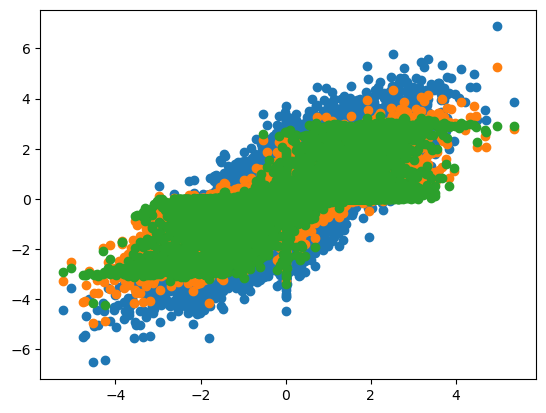

In [13]:
 
plt.scatter( xtrue, x )
plt.scatter( xtrue, resash.post_mean )
plt.scatter( xtrue, res.post_mean )

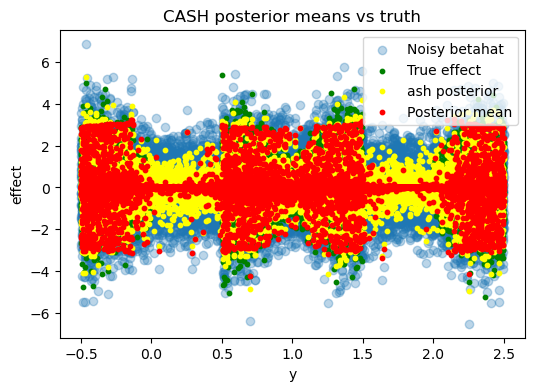

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(y, x, alpha=0.3, label="Noisy betahat")
plt.scatter(y, xtrue, c="green", s=10, label="True effect")
plt.scatter(y, resash.post_mean, c="yellow", s=10, label="ash posterior")
plt.scatter(y, res.post_mean, c="red", s=10, label="Posterior mean")
plt.legend()
plt.xlabel("y")
plt.ylabel("effect")
plt.title("CASH posterior means vs truth")
plt.show()


In [15]:

res.loss

72.16593778133392

In [16]:
resash.log_lik

-34849.44921875

In [17]:
tt[2:3]

NameError: name 'tt' is not defined

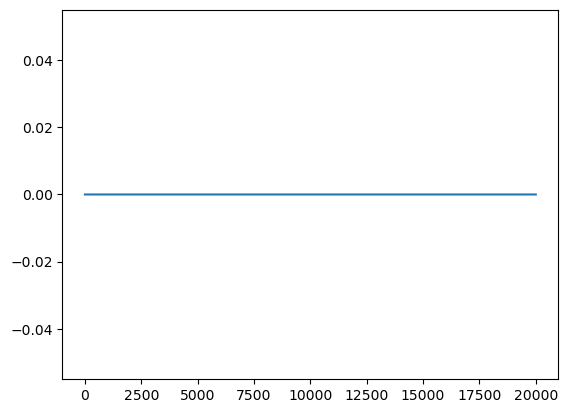

In [ ]:
plt.plot(res.location [:,0] )

In [ ]:
J = tt.shape 
K = tt.shape 

In [ ]:
J

torch.Size([4])